In [2]:
%pip install opencv numpy pandas sklearn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
plates = [
    'plates/019_jpg.rf.e73938ec62074bbde822f7d5a084bdef.jpg',
    'plates/BE9775U_png.rf.2ae51db435580876c898c833edd0f774.jpg',
    'plates/B3559SU_png.rf.da969620aaf4665b616f8f677a9a6201.jpg',
    'plates/B3326UB_png.rf.ae55e0c0bf99c732265edf021f844bf9.jpg',
    'plates/B2520XK_PNG.rf.4e22939a8917f509074397176d67c5e5.jpg',
]

images = []

for plate in plates:
    images.append(cv2.imread(plate))

In [5]:
# Define a function to process an image
def process_image(img):
    # Get image properties
    h, w, ch = img.shape

    # Normalize the image data
    data = img / 255.0

    # Reshape the data
    data = data.reshape(h * w, ch)

    return data

In [7]:
datas = []

for img in images:
    datas.append(process_image(img))

In [8]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)

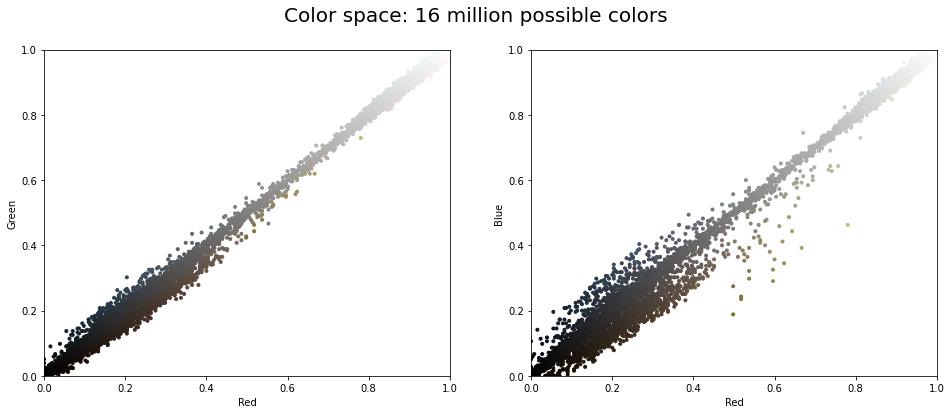

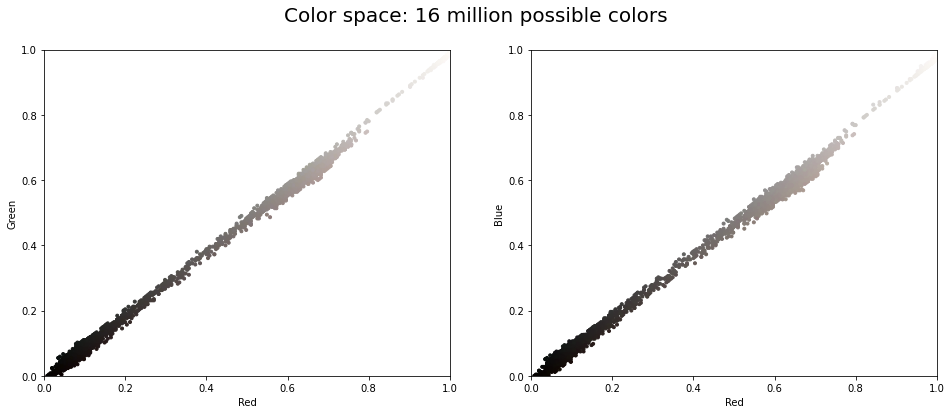

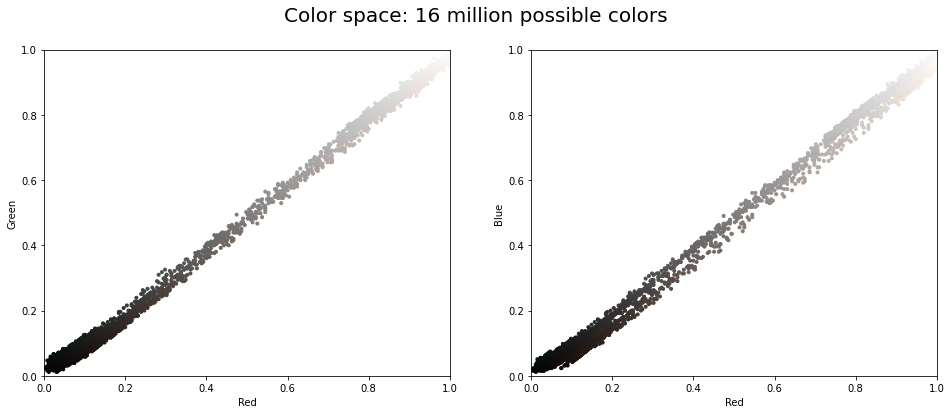

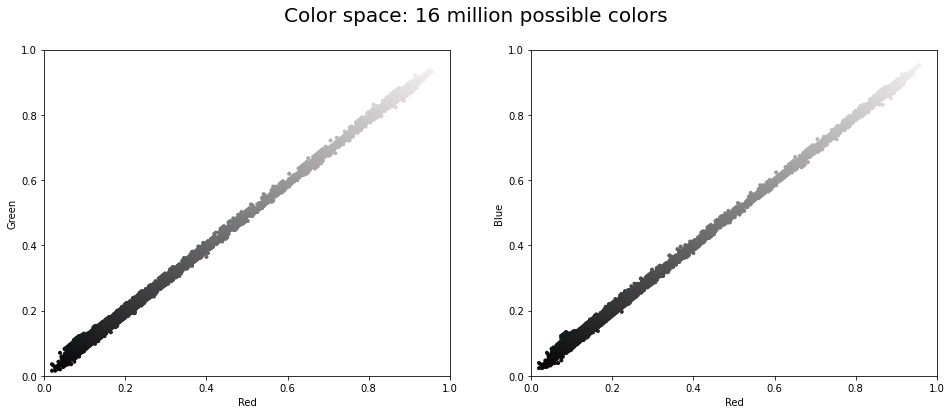

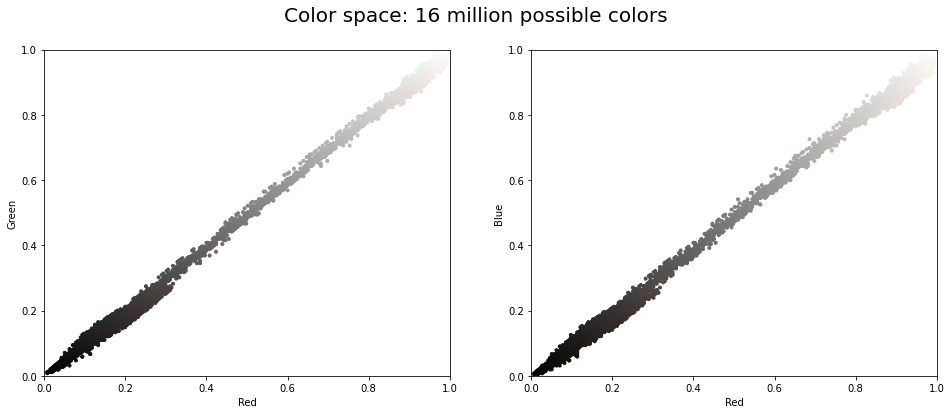

In [9]:
for data in datas:
    plot_pixels(data, title='Color space: 16 million possible colors')

In [10]:
processed_pixel_vals_list = []

def reshape_pixel(img):
    # Reshape and convert pixel values to float32
    pixel_vals = img.reshape((-1, 3))
    pixel_vals = np.float32(pixel_vals)

    # Append the processed pixel values to the list
    processed_pixel_vals_list.append(pixel_vals)

In [11]:
for img in images:
    reshape_pixel(img)

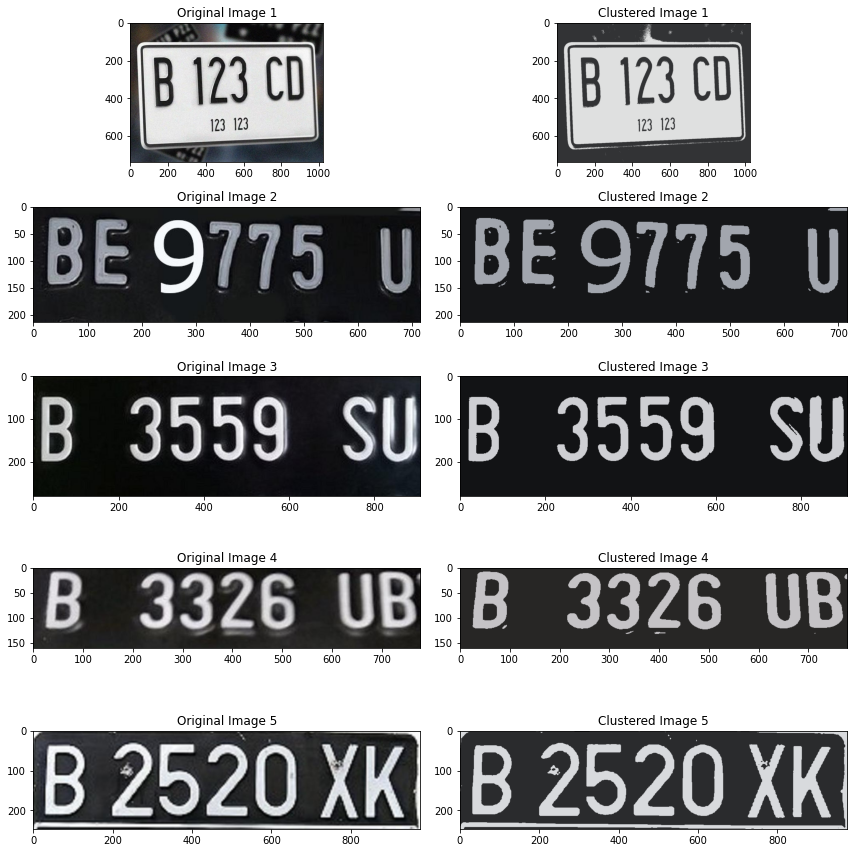

In [12]:
# K-means clustering parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
k = 2

# Create a list to store clustered images
clustered_images = []

# Create a figure to display all images
plt.figure(figsize=(12, 12))

# Ensure that 'i' is within the valid range
for i, pixel_vals in enumerate(processed_pixel_vals_list):
    if i < len(images):
        # Perform k-means clustering
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert data into 8-bit values
        centers = np.uint8(centers)
        segmented_data = centers[labels.flatten()]

        # Reshape data into the original image dimensions
        segmented_image = segmented_data.reshape((images[i].shape))
        clustered_images.append(segmented_image)

        # Display the original and clustered images in subplots
        plt.subplot(5, 2, 2 * i + 1)  # 5 rows, 2 columns
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image {i + 1}')

        plt.subplot(5, 2, 2 * i + 2)  # 5 rows, 2 columns
        plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Clustered Image {i + 1}')

plt.tight_layout()
plt.show()